<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Оптимизация с помощью гауссовских процессов

In [1]:
# Imports
import sys
import numpy as np
import numpy.linalg as LA
np.random.seed(42)

from scipy.stats import norm
from scipy.optimize import minimize

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

In [2]:
# Styles
import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['lines.linewidth'] = 2.
matplotlib.rcParams['lines.markersize'] = 10
# cm = plt.cm.tab10  # Colormap

import seaborn
seaborn.set_style('whitegrid')
figscale = 2

---

In [3]:
def f_obj(X, noise=0.):
#     return np.sin(3*X) + X**2 - 0.7*X + noise * np.random.randn(*X.shape)
    return (6*X-2)**2 * np.sin(12*X-3)
#     return X * np.sin(3*X)

# bounds = np.array([[-1.0, 2.0]])
bounds = np.array([[0., 1.]])
noise = 0.

X_init = np.array([ [bounds[0,0]], [0.5*sum(bounds[0])], [bounds[0,1]] ])
Y_init = f_obj(X_init, noise)

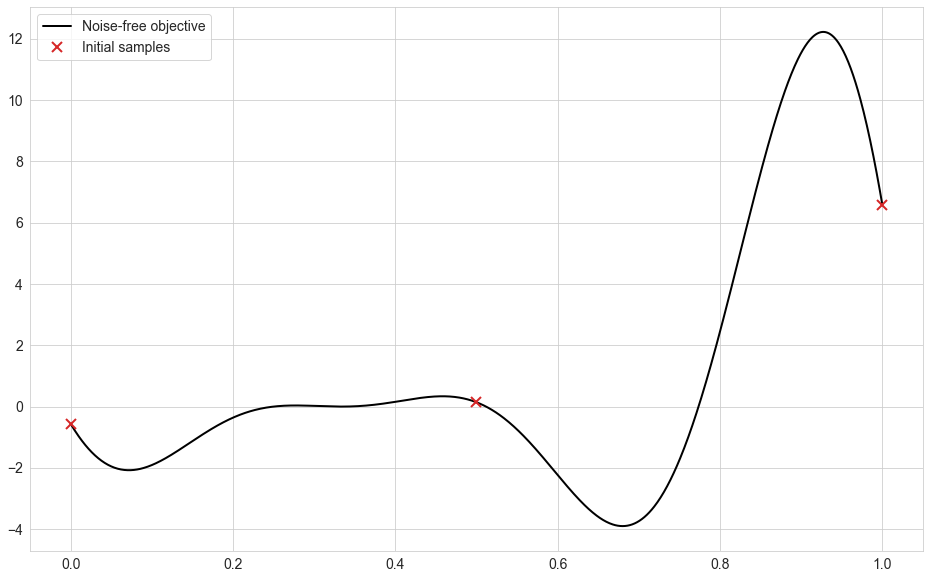

In [4]:
# Dense grid of points within bounds
X = np.linspace(bounds[:, 0], bounds[:, 1], 1001).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f_obj(X, 0)

# Plot optimization objective with noise level
plt.figure(figsize=(figscale*8, figscale*5))
plt.plot(X, Y, 'k-', label='Noise-free objective')
# plt.plot(X, f_obj(X, noise), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.plot(X_init, Y_init, 'x', c=cm.tab10(3), mew=2, label='Initial samples')
plt.legend();

---

In [5]:
# Isotropic squared exponential kernel.
def kernel(X1, X2, l=0.2, sigma_f=4):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    
    sqdist = np.sum(X1**2,1).reshape(-1,1) + np.sum(X2**2,1) - 2*np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

In [6]:
def posterior_predictive(X, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-3):
    '''
    Computes the suffiсient statistics of the GP posterior predictive distribution 
    from m training data X_train and Y_train and n new inputs X.
    
    Args:
        X: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    '''
    K = kernel(X_train, X_train) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X)
    K_ss = kernel(X, X) + 1e-6 * np.eye(len(X))
    K_inv = LA.inv(K)
    
    # mean vector
    mu_s = K_s.T @ K_inv @ Y_train

    # covariance matrix
    cov_s = K_ss - K_s.T @ K_inv @ K_s
    
    return mu_s, np.sqrt(np.diag(cov_s))

In [7]:
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=None):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * cov
    
    plt.figure(figsize=(figscale*8, figscale*5))
    plt.fill_between(
        X, mu + uncertainty, mu - uncertainty,
        color='grey', alpha=0.1, label='95% доверительный интервал')
    if samples is not None: plt.plot(X, samples, '-')
    plt.plot(X, mu, 'k', label='среднее значение')
    if X_train is not None: plt.plot(X_train.ravel(), Y_train.ravel(), 'kx', mew=1.5)
#     plt.xlim([X.min(), X.max()])
#     plt.ylim([-3, 3])
    plt.xlabel('$t$')
    plt.ylabel('$f(t)$')
    plt.legend(loc='lower right')

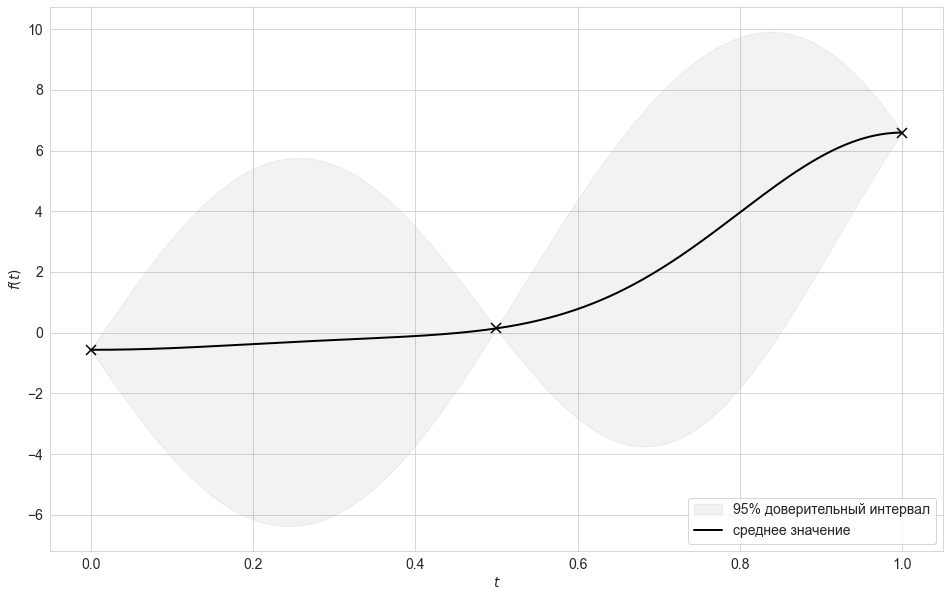

In [8]:
mu, cov = posterior_predictive(X, X_init, Y_init)
plot_gp(mu, cov, X, X_train=X_init, Y_train=Y_init)

---

Цель --- найти глобальный оптимум слева за возможно меньшее количество шагов.
Следующим шагом является реализация функции улучшения `expected_improvement`, определённой в уравнении (2). 

In [9]:
def prediction_minimum(X, X_train, Y_train, xi=0.01):
    '''
    Computes the expectation at points X based on existing samples X_train
    and Y_train using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_train: Sample locations (n x d).
        Y_train: Sample values (n x 1).
    
    Returns:
        Expectation at points X.
    '''
    mu, sigma = posterior_predictive(X, X_train, Y_train)
    mu_sample_opt = np.min(Y_train)
    em = mu_sample_opt - mu
#     em[em < 0.] = 1e-16

    return em

In [10]:
def expected_improvement(X, X_train, Y_train, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_train
    and Y_train using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_train: Sample locations (n x d).
        Y_train: Sample values (n x 1).
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = posterior_predictive(X, X_train, Y_train)
    sigma = sigma.reshape(-1, 1)
    mu_sample_opt = np.min(Y_train)

    with np.errstate(divide='warn'):
        imp = mu_sample_opt - mu - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
#         ei[sigma == 0.0] = np.PZERO

    return ei

Нам также нужна функция, которая предлагает следующую точку выборки путем вычисления местоположения максимума функции улучшения.
Оптимизация перезапускается `n_restarts` раз, чтобы избежать попадания в локальный оптимум.

In [11]:
# def propose_location(acquisition, X_train, Y_train, bounds, n_restarts=50):
#     '''
#     Proposes the next sampling point by optimizing the acquisition function.
    
#     Args:
#         acquisition: Acquisition function.
#         X_train: Sample locations (n x d).
#         Y_train: Sample values (n x 1).

#     Returns:
#         Location of the acquisition function minimum.
#     '''
    
#     dim = X_train.shape[1]
#     min_val = np.inf
#     min_x = None
    
#     def min_obj(X):
#         # Minimization objective is the negative acquisition function
#         return -acquisition(X.reshape(-1, dim), X_train, Y_train)
    
#     # Find the best optimum by starting from n_restart different random points.
#     for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
#         res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
#         if res.fun < min_val:
#             min_val = res.fun
#             min_x = res.x
    
#     return min_x.reshape(-1, 1), min_val

In [11]:
def propose_location(acquisition, X_train, Y_train, bounds, n_restarts=50):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_train: Sample locations (n x d).
        Y_train: Sample values (n x 1).

    Returns:
        Location of the acquisition function minimum.
    '''
    dim = X_train.shape[1]
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_train, Y_train)
    
    X = np.linspace(bounds[:, 0], bounds[:, 1], 1001).reshape(-1, 1)
    Y = min_obj(X)
    i_min = np.argmin(Y)
    
    return X[i_min].reshape(-1, 1), Y[i_min]

In [12]:
def plot_approximation(X, Y, X_train, Y_train, X_next=None, show_legend=False):
    mu, std = posterior_predictive(X, X_train, Y_train)
    plt.fill_between(X.ravel(), 
                     mu.ravel() + 1.96 * std.ravel(),
                     mu.ravel() - 1.96 * std.ravel(),
                     color='grey', alpha=0.1) 
    plt.plot(X, Y, '--', c='grey', label='Objective function')
    plt.plot(X, mu, 'b-', label='Surrogate function')
    plt.plot(X_train, Y_train, 'kx', mew=3, label='Train samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k')
    if show_legend:
        plt.legend()

def plot_acquisition(X, Y, X_next, show_legend=False):
    Y[Y<0] = 0
    plt.plot(X, Y, 'r-', label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', label='Next sampling location')
    if show_legend:
        plt.legend()    

In [18]:
# Initialize samples
X_train = X_init
Y_train = Y_init

# Number of iterations
n_iter = 10

# acquisition_function = prediction_minimum
def acquisition_function(X, X_train, Y_train):
#     return prediction_minimum(X, X_train, Y_train)
    return expected_improvement(X, X_train, Y_train)

0 [-1.10940192]
1 [-0.2965453]
2 [-0.15316313]
3 [-3.00998744e-05]
4 [-9.53308946e-07]
5 [-0.00018319]
6 [-1.0633303e-21]


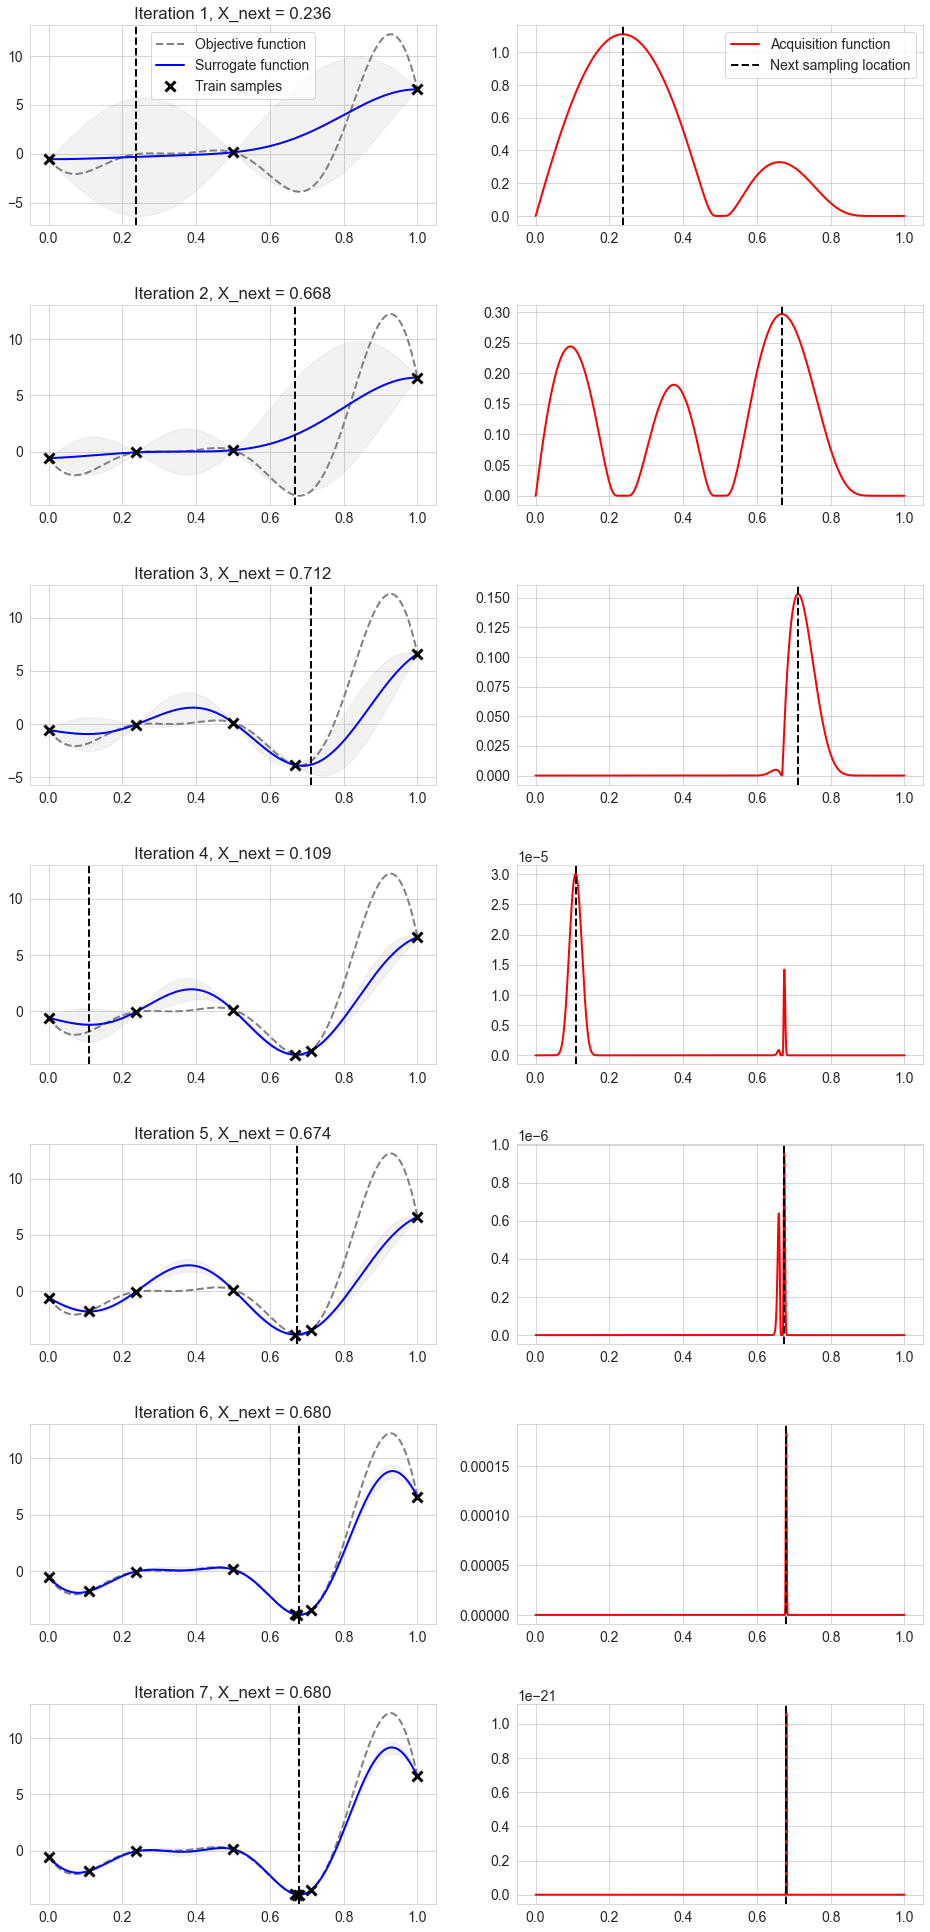

In [16]:
plt.figure(figsize=(16, n_iter * 5))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Obtain next sampling point from the acquisition function
    X_next, acq = propose_location(acquisition_function, X_train, Y_train, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = f_obj(X_next, noise)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(X, Y, X_train, Y_train, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}, X_next = {X_next[0][0]:.3f}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, acquisition_function(X, X_train, Y_train), X_next, show_legend=i==0)
    
    # Add a new sample to train samples
    X_train = np.vstack((X_train, X_next))
    Y_train = np.vstack((Y_train, Y_next))
    
    print(i, acq)
    if (-acq < 1e-16) or (abs(X_train[-2]-X_next)[0,0] < 1e-6):
        break